<a href="https://colab.research.google.com/github/brahma2024/LLM-study/blob/main/5_Building_a_Wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wavenet implemenetation
paper reference: https://arxiv.org/pdf/1609.03499

What is Wavenet architecture trying to solve for:
- In previous implementation architecture, the entire block_size i.e. the context length was being inputed into the 1st hidden layer all at once
- That is a lot of information being squeezed into the 1st hidden layer all at once, lets understand how
  - Batch_size (Examples): 32, block_size (context_length): 8, Embedding_vector for each character in the block (n_embd): 10
  - 1st hidden layer, with n_hidden: 200 is absorbing information from 8 consecutive characters each with 10 dim-vector, i.e.
  - 200 neurons in an 80-dim space is looking over/absorbing information from a 10-dim space with 8 characters at any given time

- Wavenet implementation, breaks this problem into smaller chunks for hidden layer neurons to absorb information much more gradually (e.g. of 1st hidden layer)
  + Batch_size (Examples): 32, block_size (context_length): 8, Embedding_vector for each charater in the block (n_embd): 10,
  + Plus, with n_consec: 2, input * n_consec i.e. how many consecutive inputs to visualize in the 10-dim(n_embd) for 1st layer and (n_hidden) dim space for subsequent layers, at the sametime
  + imagine this as a hidden layer with n_hidden: 200 within a 20-dim space, overlooking at a 10-dim space with 2 characters at any given time
  + this allows to assimilate more feature level information about the 2 consecutive characters


In [76]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [77]:
!wget 'https://raw.githubusercontent.com/brahma2024/LLM-study/main/names.txt'

--2024-06-26 15:46:42--  https://raw.githubusercontent.com/brahma2024/LLM-study/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228146 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2024-06-26 15:46:43 (1.74 MB/s) - ‘names.txt.1’ saved [228146/228146]



In [78]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:7])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']


In [79]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
print(chars)
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(stoi)
print(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [80]:
# shuffle the words
import random
random.seed(42)
random.shuffle(words)

In [81]:
# build the dataset
block_size = 8 # context length: Sequence of characters that are required to predict the next one

def build_dataset(words):
  X, Y = [], [] # input and output data

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '-->', itos[ix])
      context = context[1:] + [ix] # shift context window by 1 place

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


# spliting dataset: training, dev/validation, test
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [82]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [122]:
# Wrapping Layers into modules
# These modules are available in torch.nn | but we are writing them from scratch
# more detailed notes in 3 - Activations&Gradients

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------------------------------------------------------------------------------------------------------------
class BatchNorm1D:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.dim == 2: # that is the input is 2-dimension
        dim = 0 # i.e. we take the mean/var over the oth dimension
      elif x.dim == 3:
        dim = 3 # take mean/var over both the 0th and 1st dimension

      xmean = x.mean((0,1), keepdim=True) # batch mean
      xvar = x.var((0,1), keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    with torch.no_grad():
      self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
      self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ---------------------------------------------------------------------------------------------------------------------
class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return[]

# ---------------------------------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim)) # what used to be C: Embedding Matrix

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# ---------------------------------------------------------------------------------------------------------------------
class FlattenConsecutive: # pytorch Flatten implementation is slightly different | hence naming it differently

  def __init__(self, n):
    self.n = n # n: number of elements that are consecutive, that we would like to concatenate in the last dimension of the output

  def __call__(self, x):
    B, T, C = x.shape # B: batch_size, T: context length, C: Embedding Vector
    # Implementation of 3 context length | Bengio Et All
    # x = x.view()
    # self.out = x.view(x.shape[0], -1)

    # Expected wavenet implementation output
    # self.out = x.view(x.shape[0], -1, C*self.n)
    x = x.view(B, T//self.n, C*self.n) # Wavenet implementation | where T//n is integer division
    if x.shape[1] == 1: # in case there is a spurious dimension with just 1 element in the 1st dimension
      x = x.squeeze(1) # squeeze takes out a given dimention | so if T//n = 1, it returns self.out.shape = [x.shape[0], c*self.n]
    self.out = x
    return self.out

  def parameters(self):
    return []

# instead of passing layers as a naked list
# we will create a container, in which we pass in a list of layers
# then given any input in the forward pass, we just call the layers sequentially
# in terms of parameters: it is just all the parameters of the child modules
# Essentially we are rebuilding the similar API like exposed by torch.nn.Sequential
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x= layer(x)
      self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [84]:
torch.manual_seed(42); # seeding rng for reproducability

In [134]:
# Initialize parameters
# Size of the network: Initial, param: 22k
# ------
# n_embd = 10 # dimensionality of character embedding vector
# n_hidden = 200 # number of neurons in each hidden layer

# Size of the network: more layers, keeping param: 22k
# ------
# Now, previous implementation where entire block_size was inputed in one consecutive layer we used
# n_hidden = 200, which meant n_parameters = 22K
# Since wavenets, objective is to be more efficient, by building a more deeper architecture to consumer information more gradually
# we will keep n_parameters = 22K and compare the results
# n_hidden = 68
# n_consec = 2 # number of consecutive characters | wavenet implementation

# Increasing Size of the network: param: 76k
# ------
n_embd = 24
n_hidden = 128
n_consec = 2

# Here we dont maintain a naked list of layers
# We have a concept of a MODEL: which is a module
model = Sequential([
    Embedding(vocab_size, n_embd),
    # Embedding output = Embedding : (32, 8, 10) | (batch_size, block_size, Embd_dim)

    # 1st Hidden layer ops: Batch_size: 32, block_size: 8 --> split into 4 pairs of 2 consecutive each # (1, 2), (3, 4), (5, 6), (7, 8)
    FlattenConsecutive(n_consec), Linear(n_embd * n_consec, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    # 1st Hidden layer Output
    # FlattenConsecutive :  (32, 4, 20)
    # Linear :              (32, 4, 200) # each neuron/feature/channel in the Linear layer is defined by a vector (n_consec * Embd_dim)
    # BatchNorm1D :         (32, 4, 200)
    # Tanh :                (32, 4, 200)

    # 2nd hidden layer ops: 2nd hidden layer will take batch_size: 32, input_block: 2 bigram outputs (4 charac inputs) or extracted features, n_hidden: 200
    FlattenConsecutive(n_consec), Linear(n_hidden * n_consec, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    # 2nd Hidden layer Output
    # FlattenConsecutive :  (32, 2, 400) # flattens it out to (batch_size, input_block // n_consec, n_consec * n_hidden)
    # Linear :  (32, 2, 200)
    # BatchNorm1D :  (32, 2, 200)
    # Tanh :  (32, 2, 200)

    # 3rd hidden layer ops: 3rd hidden layer will take batch_size: 32, input_block: 2 extracted features of 2nd layer, n_hidden: 200
    FlattenConsecutive(n_consec), Linear(n_hidden * n_consec, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    # 3rd Hidden layer output
    # Note: here T // n = 1 since FlattenConsecutive layer gets a x.shape = 32, 2, 200 = B, T, C
    # during Flattening: x = x.view(B, T // n, C * n) | and if x[1] == 1 i.e. T // n == 1: squeeze it out, i.e. flatten it
    # to understand why is it happening: at this 3rd layer, the 1st dimension which represents the aggregated extracted feature, just has 1 dim, its squeezed out
    # FlattenConsecutive :  (32, 400)
    # Linear :  (32, 200)
    # BatchNorm1D :  (32, 200)
    # Tanh :  (32, 200)

    # Output Layer: input is batch_size: 32 and n_hidden: 200
    Linear(n_hidden, vocab_size), BatchNorm1D(vocab_size)
    # Linear :  (32, 27)
    # BatchNorm1D :  (32, 27)
])

# parameter init
# with torch.no_grad():
  # layers[-1].weight *= 0.1 # last layer make less confident | reduce overfitting

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

# print(i)

76633


In [113]:
# how many parameters each layer is contributing
total = 0
for layer in model.layers:
  total += sum(p.nelement() for p in layer.parameters())
  print(f'{layer.__class__.__name__}: {sum(p.nelement() for p in layer.parameters())} | tot: {total}')

Embedding: 270 | tot: 270
FlattenConsecutive: 0 | tot: 270
Linear: 1360 | tot: 1630
BatchNorm1D: 136 | tot: 1766
Tanh: 0 | tot: 1766
FlattenConsecutive: 0 | tot: 1766
Linear: 9248 | tot: 11014
BatchNorm1D: 136 | tot: 11150
Tanh: 0 | tot: 11150
FlattenConsecutive: 0 | tot: 11150
Linear: 9248 | tot: 20398
BatchNorm1D: 136 | tot: 20534
Tanh: 0 | tot: 20534
Linear: 1863 | tot: 22397
BatchNorm1D: 54 | tot: 22451


In [100]:
ix = torch.randint(0, Xtr.shape[0], (32,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)

torch.Size([32, 8])


In [132]:
# Understanding the mean/var calculation in the BatchNorm layer
e = torch.randn((32, 4, 68))
# since we want only n_hidden = 68 mean/vars, we calculate that over both the 0th and the 1st dimension
# pytorch allows us to give a dimension both as int or a tuple of ints
# we can reduce over multiple dimensions at the sametime
emean = e.mean((0,1), keepdim=True)
evar = e.var((0,1), keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
print(emean.shape, evar.shape, ehat.shape)
print(model.layers[3].running_mean.shape) # should gives us only 68 values for the mean

torch.Size([1, 1, 68]) torch.Size([1, 1, 68]) torch.Size([32, 4, 68])
torch.Size([1, 1, 68])


In [101]:
for layer in model.layers:
  print(layer.__class__.__name__, ': ', tuple(layer.out.shape))

Embedding :  (32, 8, 10)
FlattenConsecutive :  (32, 4, 20)
Linear :  (32, 4, 200)
BatchNorm1D :  (32, 4, 200)
Tanh :  (32, 4, 200)
FlattenConsecutive :  (32, 2, 400)
Linear :  (32, 2, 200)
BatchNorm1D :  (32, 2, 200)
Tanh :  (32, 2, 200)
FlattenConsecutive :  (32, 400)
Linear :  (32, 200)
BatchNorm1D :  (32, 200)
Tanh :  (32, 200)
Linear :  (32, 27)
BatchNorm1D :  (32, 27)


In [ ]:
print(Xb.view(Xb.shape[0], 4, -1))

In [ ]:
print(model.layers[0].out.shape) # output of Embedding layer
print(model.layers[0].out.view(model.layers[0].out.shape[0], 4, -1).shape) # 2 consecutive words as input instead of 8

In [ ]:
model.layers[1].out.shape # output of Flatten layer
# Using the flattening layer to create 2 consecutive inputs, instead of 8 consecutive inputs

In [ ]:
model.layers[2].out.shape # output of Linear layer

In [ ]:
# matrix multiplication: is a multiplicative operator between the innermost layer of mat-1 and outermost layer of mat-2
# out = x @ W1 + b1
print((torch.randn((4, 80)) @ torch.randn((80, 200)) + torch.randn(200)).shape) # shape of the output
print((torch.randn((4, 5, 2, 4, 80)) @ torch.randn((80, 200)) + torch.randn(200)).shape) # shape of the output

In [ ]:
# get all the even parts from a range of 10 numbers
list(range(10))[::2]

In [ ]:
# get all the odd parts starting at 1 from a range of 10 numbers
list(range(10))[1::2]

In [ ]:
# wavenet implementation
# (1, 2), (3, 4), (5, 6), (7, 8)
e = torch.randn((4, 8, 10)) # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
# e[:, ::2, :] # returns all even indexed values in the 2nd dimension
# e[:, 1::2, :] # returns all the odd indexed values in the 2nd dimension
# idea is to concatenate them in groups
explicit_concatenation = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
implicit_concatenation = e.view(e.shape[0], -1, 20)
print(explicit_concatenation.shape, implicit_concatenation.shape)
# to see if they are the same implementation
(e.view(4, 4, 20) == explicit_concatenation).all()

In [135]:
# Training the model
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 4.0349
  10000/ 200000: 2.0663
  20000/ 200000: 1.6476
  30000/ 200000: 1.9101
  40000/ 200000: 2.1231
  50000/ 200000: 1.9612
  60000/ 200000: 1.7100
  70000/ 200000: 1.9351
  80000/ 200000: 1.9644
  90000/ 200000: 2.1201
 100000/ 200000: 2.1406
 110000/ 200000: 1.7456
 120000/ 200000: 1.9893
 130000/ 200000: 1.7330
 140000/ 200000: 1.8236
 150000/ 200000: 1.6951
 160000/ 200000: 1.6537
 170000/ 200000: 1.5055
 180000/ 200000: 1.6951
 190000/ 200000: 1.8897


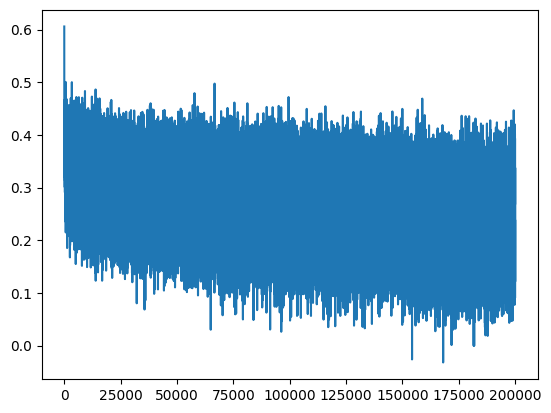

In [136]:
plt.plot(lossi)

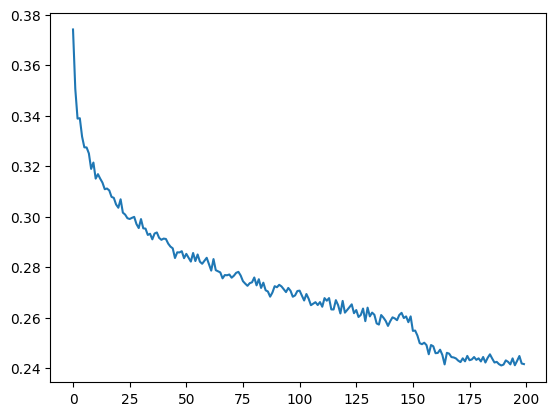

In [137]:
# average out and plot lossi, to get a more representative plot
# vieiwing lossi as [200, 1000] tensor
# take the mean across the 200 rows and plot them
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [138]:
# put layers into eval mode ( needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [139]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte,)
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)

  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.742355227470398
val 2.0093793869018555


# **performance log**
- **original context**: 3 characters, hidden neurons: 200, params: 12k
  - train: 2.058,
  - val: 2.105
- **longer context**: 8 characters, hidden neurons: 200, params: 22k
  - train: 1.9193
  - val: 2.033588
- **Wavenet Architecture**: 2 consecutive characters, hidden neurons: 68, params: 22k
  - train: 1.9065
  - val: 2.02278
- **BatchNorm Fixed**:
  - train: 1.742355
  - val: 2.0093

In [140]:
# sample from the model

for _ in range(10):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # decode and print the generated word


sidwa.
carena.
elliyah.
nory.
abrien.
nyaru.
johan.
colten.
ajourney.
damyah.
